<a href="https://colab.research.google.com/github/jtrinquier/SWAMPNN_/blob/main/colab_notebooks/demo_SWAMPNN_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/jtrinquier/SWAMPNN_.git

Cloning into 'SWAMPNN_'...
remote: Enumerating objects: 163, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 163 (delta 22), reused 139 (delta 8), pack-reused 0
Receiving objects: 100% (163/163), 36.08 MiB | 15.55 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [2]:
import pandas as pd
!  pip install git+https://github.com/deepmind/dm-haiku
import numpy as np
import string
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from jax.example_libraries.optimizers import adam
from jax.example_libraries.optimizers import sgd
import haiku as hk
import os
import re

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-lted78i0
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/dm-haiku /tmp/pip-req-build-lted78i0
  Resolved https://github.com/deepmind/dm-haiku to commit b7bb339316fc2918e59b93550a45c1ef09855a3d
  Preparing metadata (setup.py) ... done
  Created wheel for dm-haiku: filename=dm_haiku-0.0.10.dev0-py3-none-any.whl size=357596 sha256=38fd9144ceb98095a494677a8c412ac4f179fe22c9ec94f1445b4bdd2db7ab21
  Stored in directory: /tmp/pip-ephem-wheel-cache-oxprbph7/wheels/f8/08/9d/1ac74f195585dd260b70ed6bd0252a8bc0cf567cb9f5fe054e
Successfully built dm-haiku


In [3]:
import sys
sys.path.append('/content/SWAMPNN_')
import SW as SW
import LDDT_LOSS as lddt
import MPNN as MPNN
import Input_MPNN
import END_TO_END_MODELS as ete


#tmalign

In [3]:
%%bash
# get tmscore
wget -qnc https://zhanggroup.org/TM-score/TMscore.cpp
wget -qnc https://zhanggroup.org/TM-align/TMalign.cpp
g++ -static -O3 -ffast-math -lm -o TMscore TMscore.cpp
g++ -static -O3 -ffast-math -lm -o TMalign TMalign.cpp

In [4]:
import os
def tmscore(x,y):
  x,y = np.asarray(x),np.asarray(y)
  # save to dumpy pdb files
  for n,z in enumerate([x,y]): 
    out = open(f"{n}.pdb","w")
    for k,c in enumerate(z):
      out.write("ATOM  %5d  %-2s  %3s %s%4d    %8.3f%8.3f%8.3f  %4.2f  %4.2f\n" 
                  % (k+1,"CA","ALA","A",k+1,c[0],c[1],c[2],1,0))
    out.close()
  # pass to TMscore
  output = os.popen('./TMscore 0.pdb 1.pdb')
  # parse outputs
  parse_float = lambda x: float(x.split("=")[1].split()[0])
  o = {}
  for line in output:
    line = line.rstrip()
    if line.startswith("RMSD"): o["rms"] = parse_float(line)
    if line.startswith("TM-score"): o["tms"] = parse_float(line)
    if line.startswith("GDT-TS-score"): o["gdt"] = parse_float(line)
  return o

In [5]:
def tmalign(x,y):
  x,y = np.asarray(x),np.asarray(y)
  # save to dumpy pdb files
  for n,z in enumerate([x,y]): 
    out = open(f"{n}.pdb","w")
    for k,c in enumerate(z):
      out.write("ATOM  %5d  %-2s  %3s %s%4d    %8.3f%8.3f%8.3f  %4.2f  %4.2f\n" 
                  % (k+1,"CA","ALA","A",k+1,c[0],c[1],c[2],1,0))
    out.close()
  # pass to TMscore
  output = os.popen('./TMalign 0.pdb 1.pdb')
  # parse outputs
  parse_float = lambda x: float(x.split("=")[1].split()[0])
  o = {"tms":[]}
  aln = []
  aln_mode = False
  for line in output:
    line = line.rstrip()
    if line.startswith("TM-score"): o["tms"].append(parse_float(line))
    if line.startswith('(":"'): aln_mode = True
    elif aln_mode == True and len(aln) < 3: aln.append(line)
    else: aln_mode = False

  o["aln"] = aln
  aln = []
  a,b = 0,0
  for n in range(len(o["aln"][0])):
    x = o["aln"][0][n]
    y = o["aln"][2][n]
    if x != "-":
      if y != "-": aln.append(b)
      else: aln.append(-1)
    if x != "-": a += 1
    if y != "-": b += 1

  o["aln"] = np.asarray(aln)
  return o

# Prepare the input
The training data should have the following format:


```
name 1 name 2 TMS1 TMS2 aln
```

See the file data_05_SYM for an example

In [6]:
#@title Training data
training_data_path = "/content/SWAMPNN_/train_data_example/data_05_SYM" #@param {type:"string"}
list_pairs = pd.read_csv(training_data_path,sep = " ")

In [7]:
list_pairs

,name1,name2,TMS1,TMS2,aln
0,3AG3E,3AG3E,1.00000,1.00000,[ 0 1 2 3 4 5 6 7 8 9 10 ...
1,3AG3E,5AIZA,0.51778,0.50225,[ 4 6 7 8 9 10 11 12 13 14 15 ...
2,3AG3E,4EXTA,0.52271,0.55761,[-1 -1 -1 -1 -1 -1 -1 -1 -1 3 4 -1 -1 5 6 ...
3,2A0BA,2A0BA,1.00000,1.00000,[ 0 1 2 3 4 5 6 7 8 9 10 ...
4,2A0BA,3IQTA,0.71650,0.69309,[ 8 9 10 11 12 13 14 15 16 17 18 ...
...,...,...,...,...,...
19456,3CNEA,3QHPA,0.53029,0.56944,[ 1 2 3 4 5 6 7 8 9 10 11 ...
19457,3CNEA,3LLUA,0.51326,0.50649,[ 0 1 2 3 4 5 6 7 8 9 10 ...
19458,3CNEA,4ZAVA,0.59062,0.51039,[ 3 4 5 6 7 8 9 10 11 12 13 ...
19459,3CNEA,1SHUX,0.54146,0.52496,[ 4 5 6 7 8 9 10 11 12 13 14 ...


In [7]:
#@title Titre par défaut
pdb_path = "" #@param {type:"string"}
import multiprocessing as mp
print(mp.cpu_count())
def process_input(k):
  try:
    return k, Input_MPNN.get_inputs_mpnn(pdb_path+k[:-1],chain = k[-1])
  except:
    print(f"wrong format for {k}")
    return k, None

with mp.Pool(processes=mp.cpu_count()) as pool: # change the number of processes to match your CPU
  dicti_inputs = dict(pool.map(process_input, np.unique(np.array(list_pairs["name2"]))))


8


# Create train and test

Create Train and Test such that if the pair A-B is in the test set, then there is no pairs containing A or B in the train set

In [8]:
#@title Titre par défaut
max_size = 300 #@param {type:"integer"}
tm_align = True #@param {type:"boolean"}
X1 = [];X2 = [];mask1 = [];mask2 = [];chain1 = [];chain2 = [];res1 = [];res2 = []

id1 = []
id2 = []

if tm_align:
  tmaln = []
  for k in range(len(list_pairs)):
    pr1,pr2 = list_pairs["name1"][k],list_pairs["name2"][k]
    if pr1 in dicti_inputs.keys() and pr2 in dicti_inputs.keys():
      _X1,_mask1,_chain1,_res1 = dicti_inputs[pr1]
      _X2,_mask2,_chain2,_res2 = dicti_inputs[pr2]
      if len(_X1[0])<=max_size and len(_X2[0])<=max_size:
        id1.append(pr1)
        id2.append(pr2)
        X1.append(_X1[0]);X2.append(_X2[0])        
        mask1.append(_mask1[0]); mask2.append(_mask2[0])       
        chain1.append(_chain1[0]); chain2.append(_chain2[0])
        res1.append(_res1[0]); res2.append(_res2[0])
        tmaln.append(np.array([int(s) for s in re.findall(r'-?\d+', list_pairs["aln"][k])]))
else:
  for k in range(len(list_pairs)):
    pr1,pr2 = list_pairs["name1"][k],list_pairs["name2"][k]
    if pr1 in dicti_inputs.keys() and pr2 in dicti_inputs.keys():
      _X1,_mask1,_chain1,_res1 = dicti_inputs[pr1]
      _X2,_mask2,_chain2,_res2 = dicti_inputs[pr2]
      if len(_X1[0])<=max_size and len(_X2[0])<=max_size:
        id1.append(pr1)
        id2.append(pr2)
        X1.append(_X1[0]);X2.append(_X2[0])
        
        mask1.append(_mask1[0]); mask2.append(_mask2[0])
        
        chain1.append(_chain1[0]); chain2.append(_chain2[0])
        
        res1.append(_res1[0]); res2.append(_res2[0])
      

In [9]:
#@title Train test
def create_test_train(id1,id2,X_1,X_2,chain_1,chain_2,mask_1,mask_2,res_1,res_2,nb_test = 50,tma = True,tmaln = None):

  np.random.seed(0)
  print(len(X_1))
  p = np.random.permutation(len(X_1))

  X_1 = X_1[p]
  X_2 = X_2[p]
  chain_1 = chain_1[p]
  chain_2 = chain_2[p]
  res_1 = res_1[p]
  res_2 = res_2[p]
  mask_1 = mask_1[p]
  mask_2 = mask_2[p]
  if tma:
    tmaln = tmaln[p]

  id1 = id1[p]
  id2 = id2[p]

  X1test = X_1[-nb_test:] ; X2test = X_2[-nb_test:] ; chain1test = chain_1[-nb_test:] ; chain2test = chain_2[-nb_test:]; res1test = res_1[-nb_test:]; res2test = res_2[-nb_test:]; mask1test = mask_1[-nb_test:]; mask2test = mask_2[-nb_test:]
  id1test = id1[-nb_test:] ; id2test = id2[-nb_test:]
  if tma:
    tmalntest = tmaln[-nb_test:]
  k = []
  for l in range(len(X_1)-nb_test):
    if id1[l] not in id1test and id2[l] not in id2test:
      k.append(l)

  k = np.array(k)
  print("nb of training pairs",len(k))
  dicti = {}
  if tma:
    dicti["train"] = (X_1[k],X_2[k],chain_1[k],chain_2[k],mask_1[k],mask_2[k],res_1[k],res_2[k],tmaln[k])
    dicti["test"] = (X1test,X2test,chain1test,chain2test,mask1test,mask2test,res1test,res2test,tmalntest)
  else:
    dicti["train"] = (X_1[k],X_2[k],chain_1[k],chain_2[k],mask_1[k],mask_2[k],res_1[k],res_2[k])
    dicti["test"] = (X1test,X2test,chain1test,chain2test,mask1test,mask2test,res1test,res2test)
  return dicti

In [10]:
#@title Titre par défaut
nb_test = 50 #@param {type:"number"}
tm_aln = True #@param {type:"boolean"}
if tm_aln == False:
  tmaln = None
else:
  tmaln = np.array(tmaln)
dicti_train_test = create_test_train(np.array(id1),np.array(id2),np.array(X1),np.array(X2),np.array(chain1),np.array(chain2),np.array(mask1),np.array(mask2),np.array(res1),np.array(res2),nb_test = nb_test,tma = tm_aln,tmaln = tmaln)

12858
nb of training pairs 10248


<ipython-input-10-f369dd7d076b>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tmaln = np.array(tmaln)
<ipython-input-10-f369dd7d076b>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dicti_train_test = create_test_train(np.array(id1),np.array(id2),np.array(X1),np.array(X2),np.array(chain1),np.array(chain2),np.array(mask1),np.array(mask2),np.array(res1),np.array(res2),nb_test = nb_test,tma = tm_aln,tmaln = tmaln)


In [11]:
if tm_aln:
  X_1,X_2,chain_1,chain_2,mask_1,mask_2,res_1,res_2,tmaln = dicti_train_test["train"]
else:
  X_1,X_2,chain_1,chain_2,mask_1,mask_2,res_1,res_2 = dicti_train_test["train"]


# Initialize model

In [12]:
#@title Padding
def pad_(X_1, mask_1, res_1, chain_1, X_2, mask_2, res_2, chain_2, max_len):
    # Pad each element in X_1 and X_2 to the same length
    X1_padded = np.array([np.pad(X, ((0, max_len - X.shape[0]), (0, 0), (0, 0)), 'constant') for X in X_1])
    X2_padded = np.array([np.pad(X, ((0, max_len - X.shape[0]), (0, 0), (0, 0)), 'constant') for X in X_2])
    
    # Create masks, residue numbers, and chain IDs for X1_padded and X2_padded
    mask1_padded = np.array([np.pad(mask, (0, max_len - mask.shape[0]), 'constant') for mask in mask_1])
    res1_padded = np.array([np.pad(res, (0, max_len - res.shape[0]), 'constant', constant_values=-100) for res in res_1])
    chain1_padded = np.array([np.pad(chain, (0, max_len - chain.shape[0]), 'constant') for chain in chain_1])
    
    mask2_padded = np.array([np.pad(mask, (0, max_len - mask.shape[0]), 'constant') for mask in mask_2])
    res2_padded = np.array([np.pad(res, (0, max_len - res.shape[0]), 'constant', constant_values=-100) for res in res_2])
    chain2_padded = np.array([np.pad(chain, (0, max_len - chain.shape[0]), 'constant') for chain in chain_2])

        
    # Get the lengths of each element in X_1 and X_2
    len_X1 = np.array([X.shape[0] for X in X_1])
    len_X2 = np.array([X.shape[0] for X in X_2])
    
    # Combine the padded arrays, masks, residue numbers, and chain IDs into a single return tuple
    return X1_padded, mask1_padded, res1_padded, chain1_padded, X2_padded, mask2_padded, res2_padded, chain2_padded, np.column_stack((len_X1, len_X2))
def pad_tmalign(X_1, mask_1, res_1, chain_1, X_2, mask_2, res_2, chain_2, tmal, max_len):
    # Pad each element in X_1 and X_2 to the same length
    X1_padded = np.array([np.pad(X, ((0, max_len - X.shape[0]), (0, 0), (0, 0)), 'constant') for X in X_1])
    X2_padded = np.array([np.pad(X, ((0, max_len - X.shape[0]), (0, 0), (0, 0)), 'constant') for X in X_2])
    
    # Create masks, residue numbers, and chain IDs for X1_padded and X2_padded
    mask1_padded = np.array([np.pad(mask, (0, max_len - mask.shape[0]), 'constant') for mask in mask_1])
    res1_padded = np.array([np.pad(res, (0, max_len - res.shape[0]), 'constant', constant_values=-100) for res in res_1])
    chain1_padded = np.array([np.pad(chain, (0, max_len - chain.shape[0]), 'constant') for chain in chain_1])
    
    mask2_padded = np.array([np.pad(mask, (0, max_len - mask.shape[0]), 'constant') for mask in mask_2])
    res2_padded = np.array([np.pad(res, (0, max_len - res.shape[0]), 'constant', constant_values=-100) for res in res_2])
    chain2_padded = np.array([np.pad(chain, (0, max_len - chain.shape[0]), 'constant') for chain in chain_2])
    
    # Create TMALN
    TMALN = np.ones((len(X_1), max_len)) * -1
    for i in range(len(X_1)):
        tail1 = X_1[i].shape[0]
        TMALN[i, :tail1] = tmal[i][:tail1]
        
    # Get the lengths of each element in X_1 and X_2
    len_X1 = np.array([X.shape[0] for X in X_1])
    len_X2 = np.array([X.shape[0] for X in X_2])
    
    # Combine the padded arrays, masks, residue numbers, and chain IDs into a single return tuple
    return X1_padded, mask1_padded, res1_padded, chain1_padded, X2_padded, mask2_padded, res2_padded, chain2_padded, TMALN, np.column_stack((len_X1, len_X2))


In [13]:
#@title Model
num_layers = 3 #@param {type:"integer"}
num_neighbors = 48 #@param {type:"integer"}
encoding_dim = 64 #@param {type:"integer"}
categorical = False #@param {type:"boolean"}
nb_clusters = 20 #@param {type:"integer"}

bs = 15

def model_end_to_end(x1,x2,lens,t,node_features = encoding_dim,
                 edge_features = encoding_dim, hidden_dim = encoding_dim,
                 num_encoder_layers=num_layers,
                  k_neighbors=num_neighbors,categorical = categorical,nb_clusters = nb_clusters,affine = True):
  if categorical:
    a = ete.END_TO_END_SEQ_KMEANS(node_features,edge_features,hidden_dim,num_encoder_layers,k_neighbors,nb_clusters = nb_clusters,affine = True)
  else:
    a = ete.END_TO_END(node_features,edge_features,hidden_dim,num_encoder_layers,k_neighbors,affine = True)
  return a(x1,x2,lens,t)

In [ ]:
# Initialize weigths

In [14]:
if tm_align:
  X_1,X_2,chain_1,chain_2,mask_1,mask_2,res_1,res_2,_ = dicti_train_test["train"]
else:
  X_1,X_2,chain_1,chain_2,mask_1,mask_2,res_1,res_2 = dicti_train_test["train"]
MODEL_ETE = hk.transform(model_end_to_end) 
key = jax.random.PRNGKey(0)
X1,mask1,res1,chain1,X2,mask2,res2,chain2,lens = pad_(X_1[:bs],mask_1[:bs],res_1[:bs],chain_1[:bs],X_2[:bs],mask_2[:bs],res_2[:bs],chain_2[:bs],max_size)
x1 = X1,mask1,res1,chain1
x2 = X2,mask2,res2,chain2

params = MODEL_ETE.init(key,x1,x2,lens,1)

In [15]:
#@title Fine-tuning
fine_tuning = False #@param {type:"boolean"}
params_path = "/content/SWAMPNN_/models/TM_CE" #@param {type:"string"}

#fine tuning, optional
if fine_tuning:
  import pickle
  params_ = pickle.load(open(params_path,"rb"))
  for j in params_.keys():
    for k in params_[j].keys():
      params[j][k] = params_[j][k]

In [18]:
#number of parameters
compt = 0
for j in params.keys():
  for l in params[j].keys():
    compt+=params[j][l].size
print(compt)

256434


# Loss

In [16]:
#@title Loss functions
def LDDTLOSS(weights,input_data):
    X1,mask1,res1,chain1,X2,mask2,res2,chain2,lens,t,t2,mask__1,mask__2 = input_data
    x1 = X1,mask1,res1,chain1
    x2 = X2,mask2,res2,chain2 
    preds,sim_matrix,scores =MODEL_ETE.apply(weights,key,x1,x2,lens,t)
  
    scores_LDDT = lddt.get_LDDTloss(X1[:,:,1],X2[:,:,1],preds,lens,mask__1,mask__2,t2)
    aux = {"aln":preds,"sim_matrix":sim_matrix,"scores":scores,"scores_LDDT":scores_LDDT}
    loss = (1-jnp.mean(scores_LDDT))
    return loss,aux

def LDDTLOSS_CAT(weights,input_data):
    X1,mask1,res1,chain1,X2,mask2,res2,chain2,lens,t,t2,mask__1,mask__2 = input_data
    x1 = X1,mask1,res1,chain1
    x2 = X2,mask2,res2,chain2 
    preds,sim_matrix,scores,seqs =MODEL_ETE.apply(weights,key,x1,x2,lens,t)
  
    scores_LDDT = lddt.get_LDDTloss(X1[:,:,1],X2[:,:,1],preds,lens,mask__1,mask__2,t2)
    aux = {"aln":preds,"sim_matrix":sim_matrix,"scores":scores,"scores_LDDT":scores_LDDT,"seqs":seqs}
    loss = (1-jnp.mean(scores_LDDT))
    return loss,aux

def CrossEntropyLoss(weights, input_data):
    X1,mask1,res1,chain1,X2,mask2,res2,chain2,TMALN,lens,t,t2,mask__1,mask__2 = input_data
    x1 = X1,mask1,res1,chain1
    x2 = X2,mask2,res2,chain2
    preds,sim_matrix,scores =MODEL_ETE.apply(weights,key,x1,x2,lens,t)
    aux = {"aln":preds,"sim_matrix":sim_matrix,"scores":scores}
    one_hot = jax.nn.one_hot(TMALN,TMALN.shape[1])
    loss = jnp.mean(jnp.einsum("nia,nia->n",-one_hot,jnp.log(preds+10**-4))-(jnp.einsum("nia,nia->n",1-one_hot,jnp.log(1-preds+10**-4))))
    return loss,aux

def CrossEntropyLoss_CAT(weights, input_data):
    X1,mask1,res1,chain1,X2,mask2,res2,chain2,TMALN,lens,t,t2,mask__1,mask__2 = input_data
    x1 = X1,mask1,res1,chain1
    x2 = X2,mask2,res2,chain2
    preds,sim_matrix,scores,seqs =MODEL_ETE.apply(weights,key,x1,x2,lens,t)
    aux = {"aln":preds,"sim_matrix":sim_matrix,"scores":scores,"seqs":seqs}
    one_hot = jax.nn.one_hot(TMALN,TMALN.shape[1])
    loss = jnp.mean(jnp.einsum("nia,nia->n",-one_hot,jnp.log(preds+10**-4))-(jnp.einsum("nia,nia->n",1-one_hot,jnp.log(1-preds+10**-4))))
    #print(loss)
    #entro_0 = jnp.mean(seqs[0], axis=1)
    #entro_1 = jnp.mean(seqs[1], axis=1)
    #entropy = (-jnp.sum(entro_0 * jnp.log(entro_0 + 1e-8)) -jnp.sum(entro_1 * jnp.log(entro_1 + 1e-8)))*0.1
    #print(entropy)
    #loss-=entropy
    return loss,aux

In [17]:
opt_init, opt_update, get_params = adam(1/1e3)
opt_state = opt_init(params)
if tm_align:
  if categorical:
    @jax.jit
    def train_step(step_i, opt_state, loss_data):
        net_params = get_params(opt_state)
        (loss,aux), grads = jax.value_and_grad(CrossEntropyLoss_CAT, argnums=0,has_aux=True)(net_params, loss_data)

        return (loss,aux), opt_update(step_i, grads, opt_state)
  else:
    @jax.jit
    def train_step(step_i, opt_state, loss_data):
        net_params = get_params(opt_state)
        (loss,aux), grads = jax.value_and_grad(CrossEntropyLoss, argnums=0,has_aux=True)(net_params, loss_data)

        return (loss,aux), opt_update(step_i, grads, opt_state) 
else:
  if categorical:
    @jax.jit
    def train_step(step_i, opt_state, loss_data):
        net_params = get_params(opt_state)
        (loss,aux), grads = jax.value_and_grad(LDDTLOSS_CAT, argnums=0,has_aux=True)(net_params, loss_data)

        return (loss,aux), opt_update(step_i, grads, opt_state)
  else:
    @jax.jit
    def train_step(step_i, opt_state, loss_data):
        net_params = get_params(opt_state)
        (loss,aux), grads = jax.value_and_grad(LDDTLOSS, argnums=0,has_aux=True)(net_params, loss_data)

        return (loss,aux), opt_update(step_i, grads, opt_state)

# Training

In [19]:
#@title Training
epochs = 50 #@param {type:"integer"}
T_start = 5 #@param {type:"number"}
T_end = 0.1 #@param {type:"number"}

bs = 20
nb_b = int((len(X_1))//bs-1)
print(nb_b)

for j in range(epochs):
    t = T_start-(j/epochs)*(T_start-T_end)
    print("Temperature: ",t)
    print("Epoch: ",j)

    if j%1 == 0:
      if tm_align:
        X1,mask1,res1,chain1,X2,mask2,res2,chain2,TMALN,lens = pad_tmalign(X_1[-bs:],mask_1[-bs:],res_1[-bs:],chain_1[-bs:],X_2[-bs:],mask_2[-bs:],res_2[-bs:],chain_2[-bs:],tmaln[-bs:],max_size)
      else:
        X1,mask1,res1,chain1,X2,mask2,res2,chain2,lens = pad_(X_1[-bs:],mask_1[-bs:],res_1[-bs:],chain_1[-bs:],X_2[-bs:],mask_2[-bs:],res_2[-bs:],chain_2[-bs:],max_size)
      x1 = X1,mask1,res1,chain1
      x2 = X2,mask2,res2,chain2
      mask__1 = np.zeros((bs,max_size,max_size))
      mask__2 = np.zeros((bs,max_size,max_size))

      for j in range(X1.shape[0]):
          mask__1[j,:lens[j,0],:lens[j,0]] = 1
          mask__2[j,:lens[j,1],:lens[j,1]] = 1
      if tm_align:
        x = X1,mask1,res1,chain1,X2,mask2,res2,chain2,TMALN,lens,t,t,mask__1,mask__2
        if categorical:
          temp1 = CrossEntropyLoss_CAT(get_params(opt_state),x)[0]
        else:
          temp1 = CrossEntropyLoss(get_params(opt_state),x)[0]        
      else:
        x = X1,mask1,res1,chain1,X2,mask2,res2,chain2,lens,t,t,mask__1,mask__2
        if categorical:
          temp1 = LDDTLOSS_CAT(get_params(opt_state),x)[0]
        else:
          temp1 = LDDTLOSS(get_params(opt_state),x)[0]

      print(temp1," Validation loss")


    losses = [] ## Record loss of each batch
    for i in np.arange(nb_b):
      if tm_align:
        X1,mask1,res1,chain1,X2,mask2,res2,chain2,TMALN,lens = pad_tmalign(X_1[i*bs:(i+1)*bs],mask_1[i*bs:(i+1)*bs],res_1[i*bs:(i+1)*bs],chain_1[i*bs:(i+1)*bs],X_2[i*bs:(i+1)*bs],mask_2[i*bs:(i+1)*bs],res_2[i*bs:(i+1)*bs],chain_2[i*bs:(i+1)*bs],tmaln[i*bs:(i+1)*bs],max_size)
      else:
        X1,mask1,res1,chain1,X2,mask2,res2,chain2,lens = pad_(X_1[i*bs:(i+1)*bs],mask_1[i*bs:(i+1)*bs],res_1[i*bs:(i+1)*bs],chain_1[i*bs:(i+1)*bs],X_2[i*bs:(i+1)*bs],mask_2[i*bs:(i+1)*bs],res_2[i*bs:(i+1)*bs],chain_2[i*bs:(i+1)*bs],max_size)
      x1 = X1,mask1,res1,chain1
      x2 = X2,mask2,res2,chain2
      mask__1 = np.zeros((bs,max_size,max_size))
      mask__2 = np.zeros((bs,max_size,max_size))

      for j in range(X1.shape[0]):
          mask__1[j,:lens[j,0],:lens[j,0]] = 1
          mask__2[j,:lens[j,1],:lens[j,1]] = 1
      if tm_align:
        x = X1,mask1,res1,chain1,X2,mask2,res2,chain2,TMALN,lens,t,t,mask__1,mask__2
      else:
        x = X1,mask1,res1,chain1,X2,mask2,res2,chain2,lens,t,t,mask__1,mask__2

      (loss,aux), opt_state = train_step(j, opt_state, x)

      if i%500==0:
        print(i)
        print(loss,"loss batch")
        if categorical:
          print(np.argmax(aux["seqs"][0][0],-1))
      losses.append(loss) 

    print("Loss : {:.3f}".format(jnp.array(losses).mean()))

511
Temperature:  1.0
Epoch:  0
184.94316  Validation loss
0
120.7073 loss batch
500
162.36992 loss batch
Loss : 182.552
Temperature:  0.91
Epoch:  1
178.00183  Validation loss
0
119.62428 loss batch
500
151.302 loss batch
Loss : 178.228
Temperature:  0.82
Epoch:  2
180.47603  Validation loss
0
116.86757 loss batch
500
154.47998 loss batch
Loss : 174.149
Temperature:  0.73
Epoch:  3
190.13133  Validation loss
0
118.85187 loss batch
500
153.94365 loss batch
Loss : 170.647
Temperature:  0.6399999999999999
Epoch:  4
189.57588  Validation loss
0
118.12675 loss batch
500
148.40953 loss batch
Loss : 171.896
Temperature:  0.55
Epoch:  5
192.96315  Validation loss
0
116.0944 loss batch
500
150.38237 loss batch
Loss : 169.662
Temperature:  0.45999999999999996
Epoch:  6
205.53914  Validation loss
0
121.793755 loss batch
500
146.73245 loss batch
Loss : 171.948
Temperature:  0.37
Epoch:  7
209.98782  Validation loss
0
128.82884 loss batch
500
150.09543 loss batch
Loss : 176.308
Temperature:  0.279

In [28]:
import pickle
params = get_params(opt_state)
with open("/content/SWAMPNN_/models/TM_CE",'wb') as fff:
  pickle.dump(params,fff)

In [20]:
l =  5
tmscore(X1[l,:lens[l][0],1],aux["aln"][l][:lens[l][0],:lens[l][1]]@X2[l,:lens[l][1],1])

{'rms': 14.179, 'tms': 0.8181, 'gdt': 0.705}

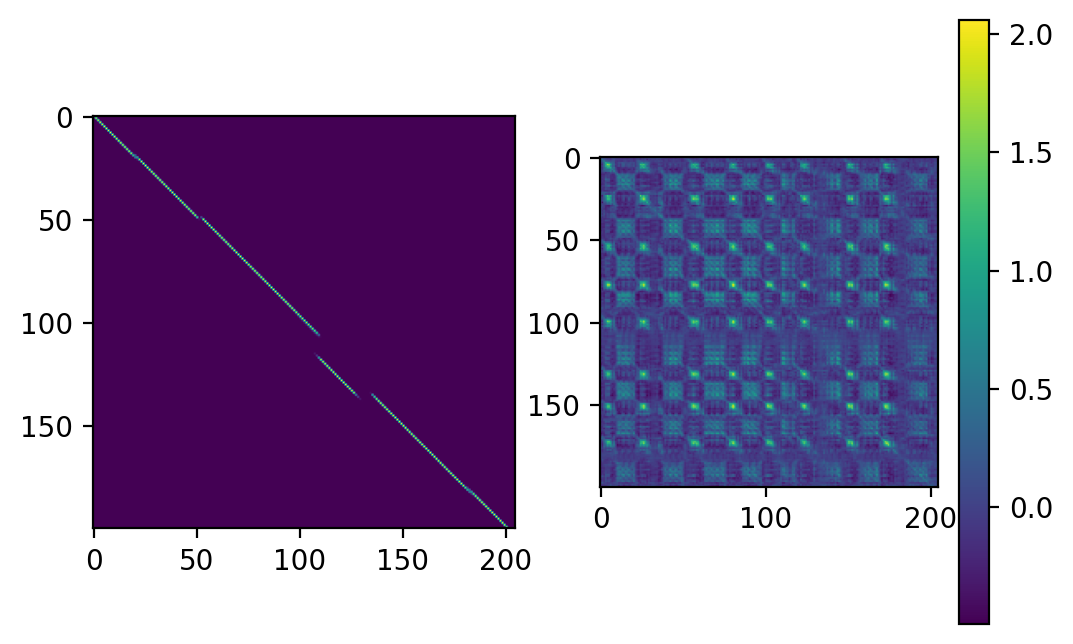

In [21]:
plt.figure(dpi = 200)
plt.subplot(121)

plt.imshow(aux['aln'][l][:lens[l,0],:lens[l,1]])
plt.subplot(122)
plt.imshow(aux['sim_matrix'][l][:lens[l,0],:lens[l,1]])
plt.colorbar()

# Test

In [22]:
if tm_align:
  X_1t,X_2t,chain_1t,chain_2t,mask_1t,mask_2t,res_1t,res_2t,tmalnt = dicti_train_test["test"]
else:
  X_1t,X_2t,chain_1t,chain_2t,mask_1t,mask_2t,res_1t,res_2t = dicti_train_test["test"]

In [23]:
@jax.jit 
def align(input_data,weights):
  X1,mask1,res1,chain1,X2,mask2,res2,chain2,lens,t = input_data
  x1 = X1,mask1,res1,chain1
  x2 = X2,mask2,res2,chain2
  return MODEL_ETE.apply(weights,key, x1,x2,lens,t)[0]

In [32]:
k = nb_test
bs = 10

if tm_align:
  X1,mask1,res1,chain1,X2,mask2,res2,chain2,TMALN,lens = pad_tmalign(X_1t,mask_1t,res_1t,chain_1t,X_2t,mask_2t,res_2t,chain_2t,tmalnt,max_size)
else:
  X1,mask1,res1,chain1,X2,mask2,res2,chain2,lens = pad_(X_1t,mask_1t,res_1t,chain_1t,X_2t,mask_2t,res_2t,chain_2t,max_size)


score_reconstruc = np.zeros(k)
score_tm = np.zeros(k)

for i in range(k//bs):
  print(i)
  input_data = X1[i*bs:(i+1)*bs],mask1[i*bs:(i+1)*bs],res1[i*bs:(i+1)*bs],chain1[i*bs:(i+1)*bs],X2[i*bs:(i+1)*bs],mask2[i*bs:(i+1)*bs],res2[i*bs:(i+1)*bs],chain2[i*bs:(i+1)*bs],lens[i*bs:(i+1)*bs],0.001
  soft_aln = align(input_data,params)

  for j in range(bs):
    if tm_align:
      temp1 = tmscore(X_1t[i*bs+j][:,1],jax.nn.one_hot(TMALN[i*bs+j][:lens[i*bs+j][0]],lens[i*bs+j][1])@X_2t[i*bs+j][:,1])
      score_tm[j+i*bs] = temp1["tms"]
    temp2 = tmscore(X_1t[i*bs+j][:,1],soft_aln[j,:lens[i*bs+j][0],:lens[i*bs+j][1]]@X_2t[i*bs+j][:,1])
    score_reconstruc[j+i*bs] = temp2["tms"]
    #print(score_reconstruc[j+i*bs]," MODEL")
    #print(score_tm[j+i*bs]," TM")


0
1
2
3
4


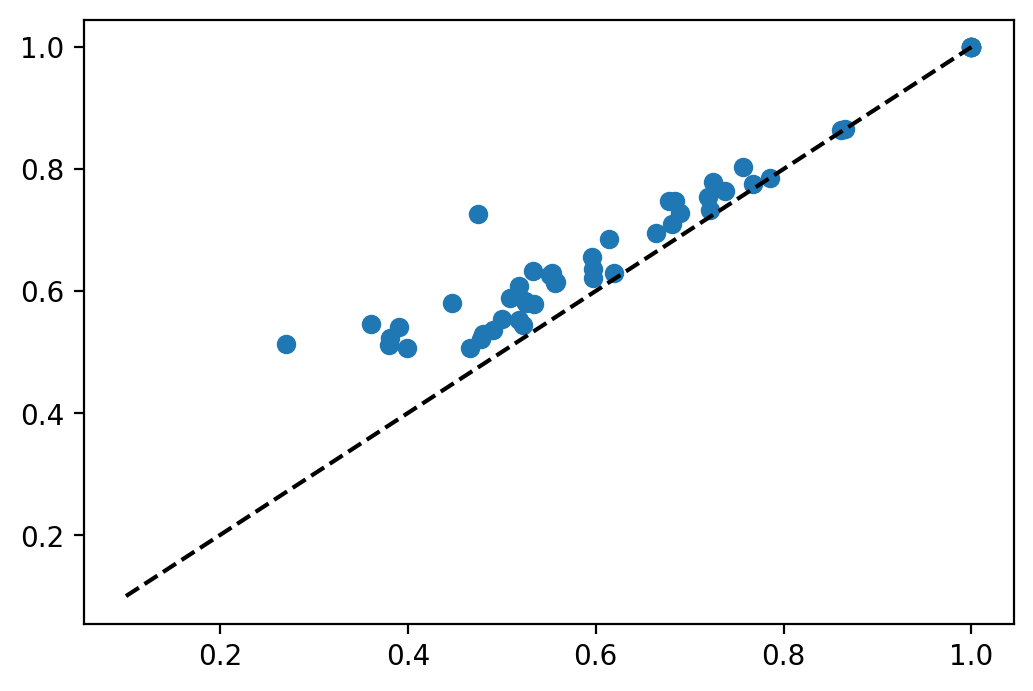

In [31]:
plt.figure(dpi = 200)
plt.scatter(score_reconstruc,score_tm)
plt.plot([0.1,1],[0.1,1],"--k")